In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
import matplotlib
import cm_xml_to_matplotlib as make_cmap

import celeri

plt.rcParams["text.usetex"] = False


In [107]:
# Constants and parameters
N_GRID_X = 500
N_GRID_Y = 500
N_CONTOUR_LEVELS = 12
MAKE_EIGENVECTOR_EXAMPLE_PLOT = False

cmap = make_cmap.make_cmap("w_ymiddle1.xml")

In [4]:
def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate(fill_value):
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, N_GRID_X)
    y_vec = np.linspace(38, 52, N_GRID_Y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = scipy.interpolate.RBFInterpolator(
        xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
    )(xflat)
    ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
    return xgrid, ygrid


def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    tri_centroid_to_mesh_centroid_distance = np.sqrt(
        tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
    )
    dip_slip_distribution = np.exp(
        -((tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    )
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(
        dip_slip_distribution.size
    )  # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements


def plot_slip_distributions(
    slip_distribution_input, slip_distribution_estimated, suptitle_string
):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    interpolate_and_plot(slip_distribution_input[0::2])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    interpolate_and_plot(slip_distribution_estimated[0::2])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    interpolate_and_plot(slip_distribution_input[1::2])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    interpolate_and_plot(slip_distribution_estimated[1::2])

    plt.suptitle(suptitle_string)
    plt.show()


def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    # If the fill value has very little variation so it can be contoured
    if fill_value.ptp() < 1e-4:
        fill_value = 1e-4 * np.ones_like(fill_value)

    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, N_CONTOUR_LEVELS)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


def make_eigenvector_example_plot():
    n_eigenvalues = 110
    eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
        n_eigenvalues, meshes[0].x_centroid, meshes[0].y_centroid, meshes[0].z_centroid
    )

    # Plot select eigenmodes
    plt.figure(figsize=(16, 13))

    for i in range(0, 18):
        ax = plt.subplot(3, 6, i + 1)

        # Shift eigenmodes by plotting row to show some dynamic range
        if i > 5 and i <= 11:
            i = i - 6 + 30
        elif i > 11:
            i = i - 12 + 100
        fill_value = fill_value = eigenvectors[:, i]

        # Normalize fill_value for interpretable plotting
        min_value = np.min(fill_value)
        max_value = np.max(fill_value)
        if np.abs(max_value) > np.abs(min_value):
            fill_value = fill_value / max_value
        else:
            fill_value = fill_value / np.abs(min_value)

        if i == 0 and np.nanmean(fill_value) < 0:
            fill_value = -1 * fill_value

        interpolate_and_plot(fill_value)
        plt.title(f"mode {i}")

    plt.savefig("eigenvector_examples.pdf")
    plt.savefig("eigenvector_examples.png", dpi=500)
    plt.show()


def get_synthetic_displacements_test(mesh, sources, tde_matrix, observation_noise):
    n_vels = tde_matrix.shape[0]
    slip_distribution = np.zeros(2 * mesh.n_tde)
    strike_slip_distribution = np.zeros(mesh.n_tde)
    dip_slip_distribution = np.zeros(mesh.n_tde)

    for i in range(sources.lon.size):
        source_to_mesh_centroid_lon = mesh.centroids[:, 0] - sources.lon[i]
        source_to_mesh_centroid_lat = mesh.centroids[:, 1] - sources.lat[i]

        source_to_mesh_centroid_distance = np.sqrt(
            source_to_mesh_centroid_lon**2.0 + source_to_mesh_centroid_lat**2.0
        )

        # Guassian slip pattern
        if sources.slip_type[i] == "strike_slip":
            strike_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )
        elif sources.slip_type[i] == "dip_slip":
            dip_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )

    slip_distribution[0::2] = strike_slip_distribution  # Strike slip only
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only

    # Forward calculation of synthetic displacments
    synthetic_displacements = tde_matrix @ slip_distribution

    # Add noise to synthetic displacments
    synthetic_displacements += observation_noise * np.random.randn(n_vels)

    return slip_distribution, synthetic_displacements


def plot_meshes(meshes, fill_value, ax, cmap_string):
    x_coords = meshes[0].meshio_object.points[:, 0]
    y_coords = meshes[0].meshio_object.points[:, 1]
    vertex_array = np.asarray(meshes[0].verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts,
        edgecolor="k",
        cmap=cmap_string,
        linewidth=0.1,
        alpha=1.0,
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.gca().set_aspect("equal")
    return pc


In [5]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)


2022-09-05 23:19:15.377 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2022-09-05 23:19:15.377 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2022-09-05-23-19-15
2022-09-05 23:19:15.378 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2022-09-05-23-19-15/2022-09-05-23-19-15.log
2022-09-05 23:19:15.378 | INFO     | celeri.celeri:read_data:129 - Reading data files
2022-09-05 23:19:15.382 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2022-09-05 23:19:15.384 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2022-09-05 23:19:15.385 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2022-09-05 23:19:15.410 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/cascadia.msh
2022-09-05 23:19:15.413 | SUCCESS  | celeri.celeri:read_data:301 - Read: ../data/station/western_north_america_station.csv
2022-09-05 23:19:15.414 | INFO     | celeri.celeri:read_data:316 - No mogi_file_name
2022-09-05 23:19:15.415 | INFO     | celeri.celeri:read_data:338 - No sar_file_name


# Outline
1. Calculate kinematically informed random epicenter
   - Pick a mesh element (`np.random.choice`) with probability:
     $$P(c(t)) = \frac{1}{1+e^{-c(t)}} + \mathrm{history}$$
     where $c(t)$ is the coupling rate at time ($t$).  This is an instantaneous formulation.  We could also do this with a more history dependent formulation.  This could include dropping probabilities after an event ruptures a triangular element much like a "state" effect.  This could sort of halo certain regions
2. Calculate random magnitude 
   - Could be Gutenberg Ricter or drawn from a history dependent Omori style aftershock frequency law
   - Gutenberg Ricter formulation:
     ```python
     def gr_magnitude(n_eq, b_vale, m_min):
         # From http://www.geos.ed.ac.uk/homes.abe115/Quake_sim.py
         rng = np.random.RandomState()
         magnitudes = m_min + rng.exponential(1.0 /
                              (-b_value / np.log10(np.e)), n_eq)
         return mangitudes
     ```
3. Calculate approximate rupture area, $a$ 
   - Empirical scaling law (Plescia and Hayes, Wells and Coppersmith)
4. Find subset of $n$ triangles with areas that sum to $a+$  some factor
$$a^{+}< \alpha_t \sum_k a_k$$
5. Calculate eigenfunctions for these triangles
6. Generate random Gaussian slip pattern
	- Should I taper towards edges?
7. Rescale random Gaussian slip pattern to get the magnitude correct

In [44]:
# Dictionary for storing `event` information for a single earthquake
event = addict.Dict()

In [45]:
# Select random event magnitude from GR distribution
def get_gutenberg_richter_magnitudes(n_earthquakes, b_value, minimum_magnitude):
    rng = np.random.RandomState()
    magnitudes = minimum_magnitude + rng.exponential(
        1.0 / (-b_value / np.log10(np.e)), n_earthquakes
    )
    return magnitudes

# Select magnitude
n_earthquakes = 1
b_value = -1.0
minimum_magnitude = 7.0
event.magnitude = get_gutenberg_richter_magnitudes(
    n_earthquakes, b_value, minimum_magnitude
)


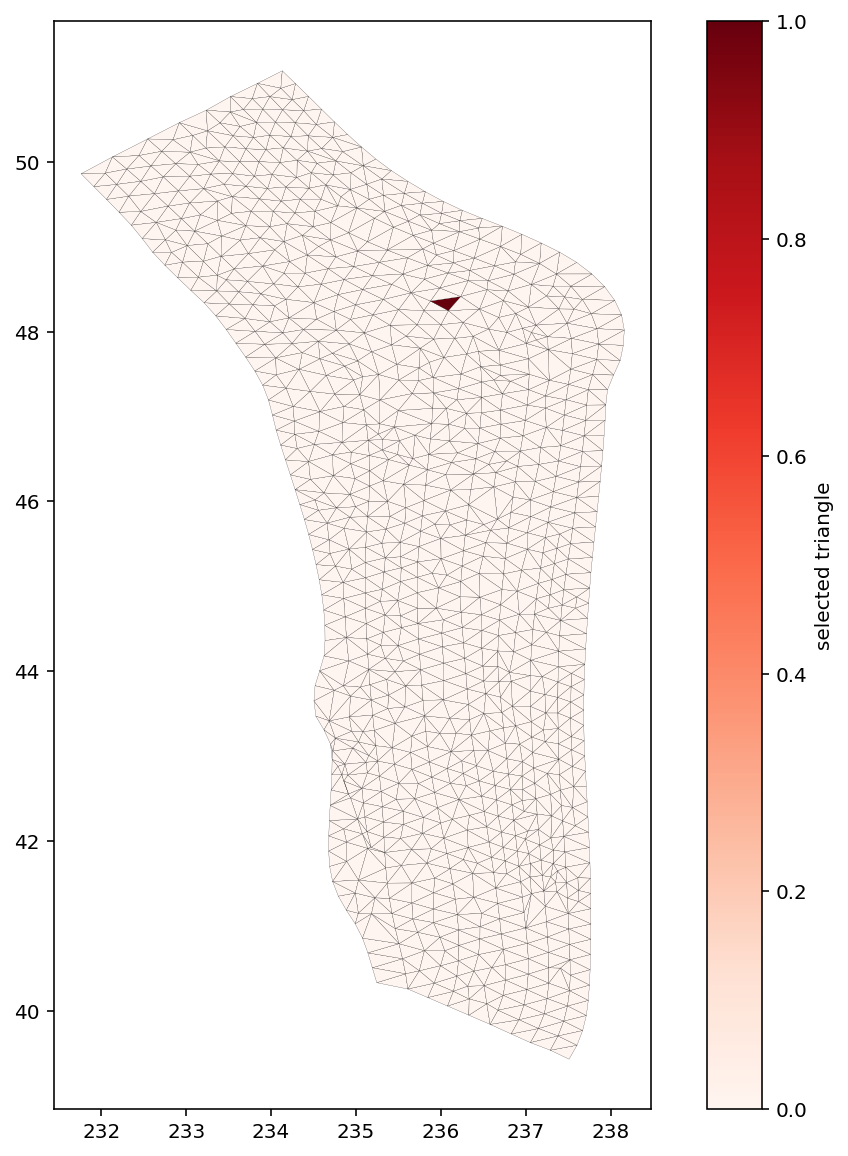

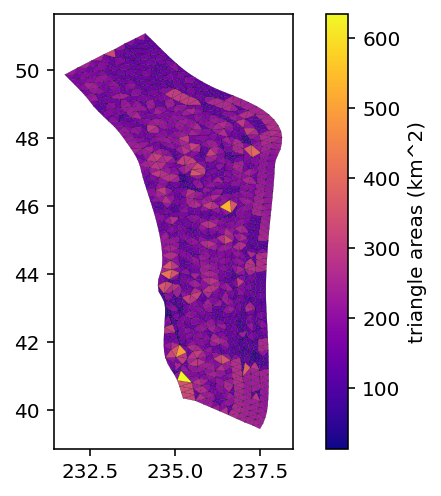

In [68]:
# Select random triangle
# Should be based on coupling or slip deficit rate/history
triangle_probabilities = np.ones(meshes[0].n_tde) / meshes[0].n_tde
event.hypocenter_triangle_index = np.random.choice(
    meshes[0].n_tde, 1, p=triangle_probabilities
)
fill_value = np.zeros(meshes[0].n_tde)
fill_value[event.hypocenter_triangle_index] = 1


total_mesh_area/1e6=329459.0686337566


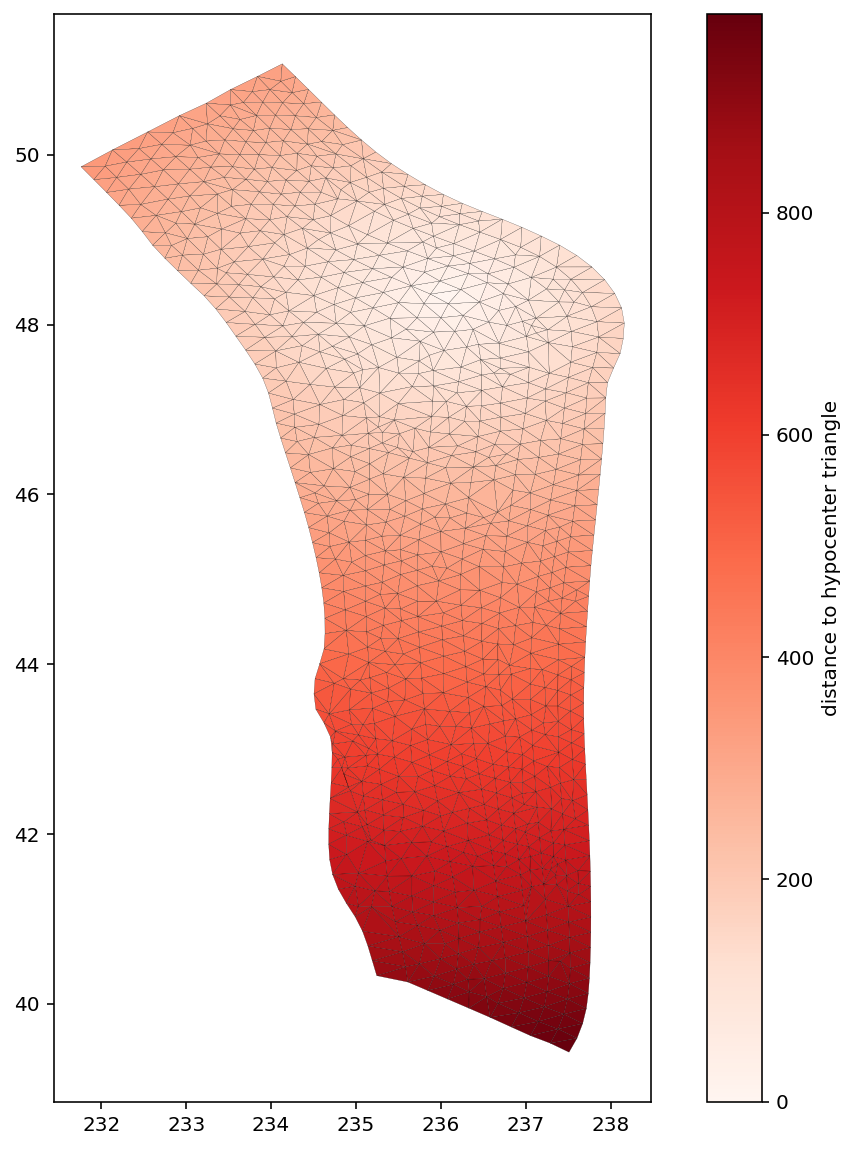

In [70]:
total_mesh_area = np.sum(meshes[0].areas)
print(f"{total_mesh_area/1e6=}")

# Convert magnitude to area and slip
event.area = 0

# Find distance between current index mesh triangle all others
x_centroid = (
    meshes[0].x_centroid[event.hypocenter_triangle_index] - meshes[0].x_centroid
)
y_centroid = (
    meshes[0].y_centroid[event.hypocenter_triangle_index] - meshes[0].y_centroid
)
z_centroid = (
    meshes[0].z_centroid[event.hypocenter_triangle_index] - meshes[0].z_centroid
)

all_triangle_cartesian_centroid_coordinates = np.vstack(
    (x_centroid, y_centroid, z_centroid)
).T

hypocenter_triangle_cartesian_centroid_coordinates = np.array(
    [
        x_centroid[event.hypocenter_triangle_index],
        y_centroid[event.hypocenter_triangle_index],
        z_centroid[event.hypocenter_triangle_index],
    ]
).T

hypocenter_triangle_to_all_triangles_distances = scipy.spatial.distance.cdist(
    hypocenter_triangle_cartesian_centroid_coordinates,
    all_triangle_cartesian_centroid_coordinates,
    "euclidean",
)

hypocenter_triangle_to_all_triangles_distances = np.squeeze(hypocenter_triangle_to_all_triangles_distances)

plt.figure(figsize=(10, 10))
pc = plot_meshes(meshes, hypocenter_triangle_to_all_triangles_distances / 1e3, plt.gca(), "Reds")
plt.colorbar(pc, label="distance to hypocenter triangle")
plt.show()


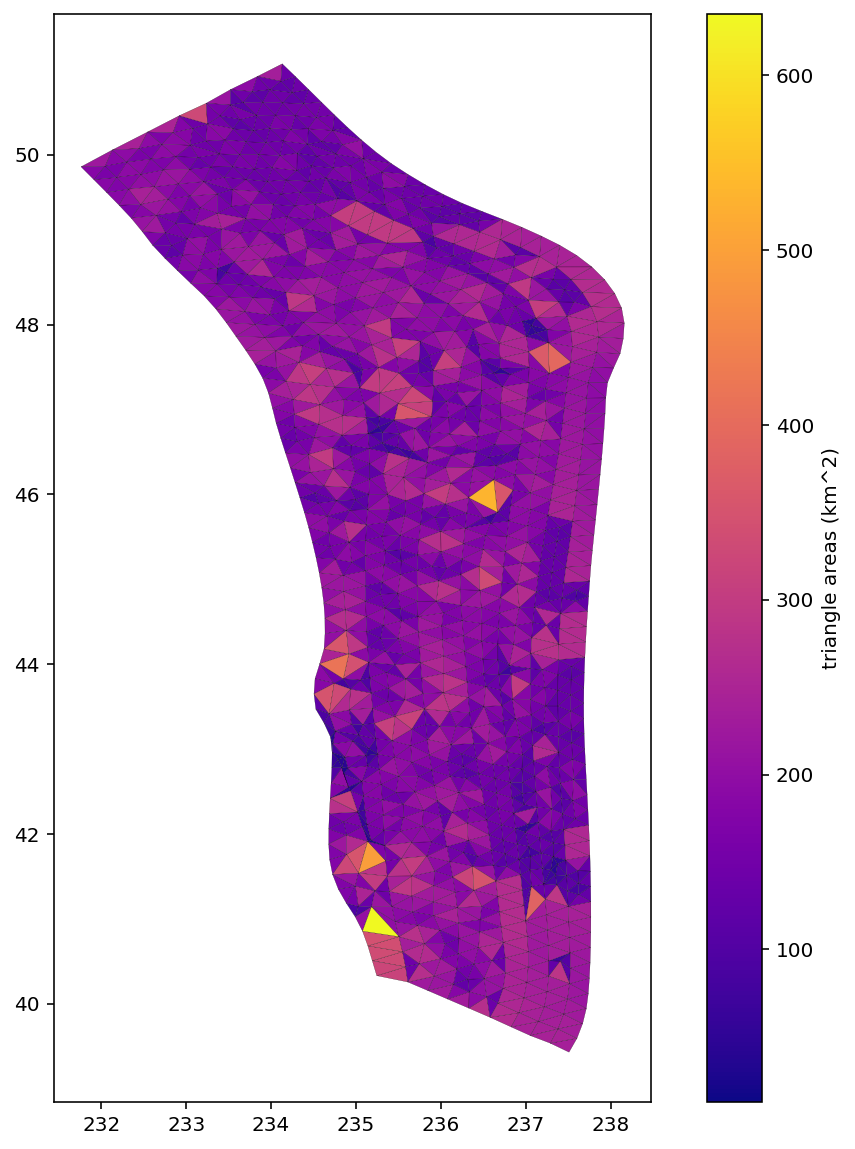

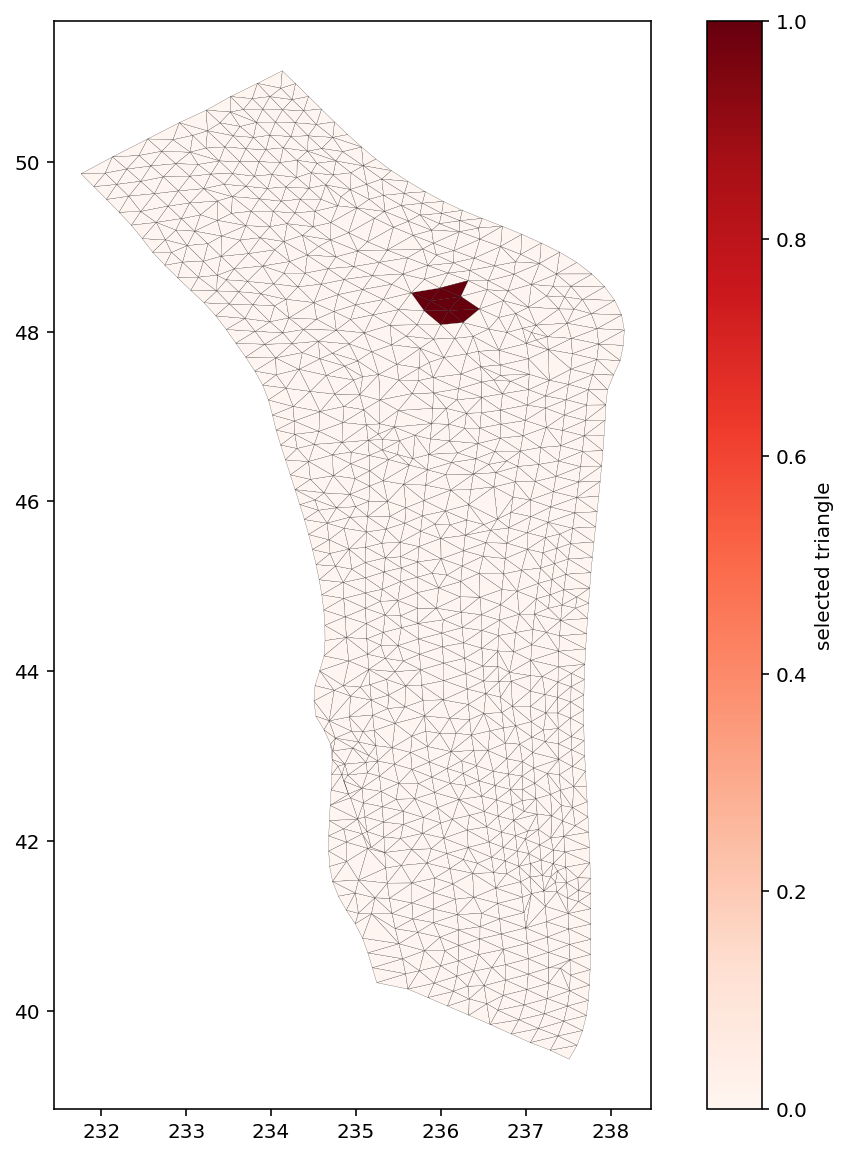

In [241]:
# Find the triangles close to the hypocenter that accumulate enough area to be a 
# part of the event rupture

# Plot all triangle areas for reference
plt.figure(figsize=(10, 10))
pc = plot_meshes(meshes, meshes[0].areas / 1e6, plt.gca(), "plasma")
plt.colorbar(pc, label="triangle areas (km^2)")
plt.show()

event.target_area = 2000e6

# Sort indices of hypocenter to centroid distances
sorted_distance_index = np.argsort(hypocenter_triangle_to_all_triangles_distances)
cumulative_area = np.cumsum(meshes[0].areas[sorted_distance_index])
event.triangle_index = sorted_distance_index[np.where(cumulative_area < event.target_area)[0]] # TODO: add extra factor here?
event.actual_area = np.sum(meshes[0].areas[event.triangle_index])

# Plot triangle location
fill_value = np.zeros(meshes[0].n_tde)
fill_value[event.triangle_index] = 1
plt.figure(figsize=(10, 10))
pc = plot_meshes(meshes, fill_value, plt.gca(), "Reds")
plt.colorbar(pc, label="selected triangle")
plt.show()



IndexError: index 30 is out of bounds for axis 1 with size 10

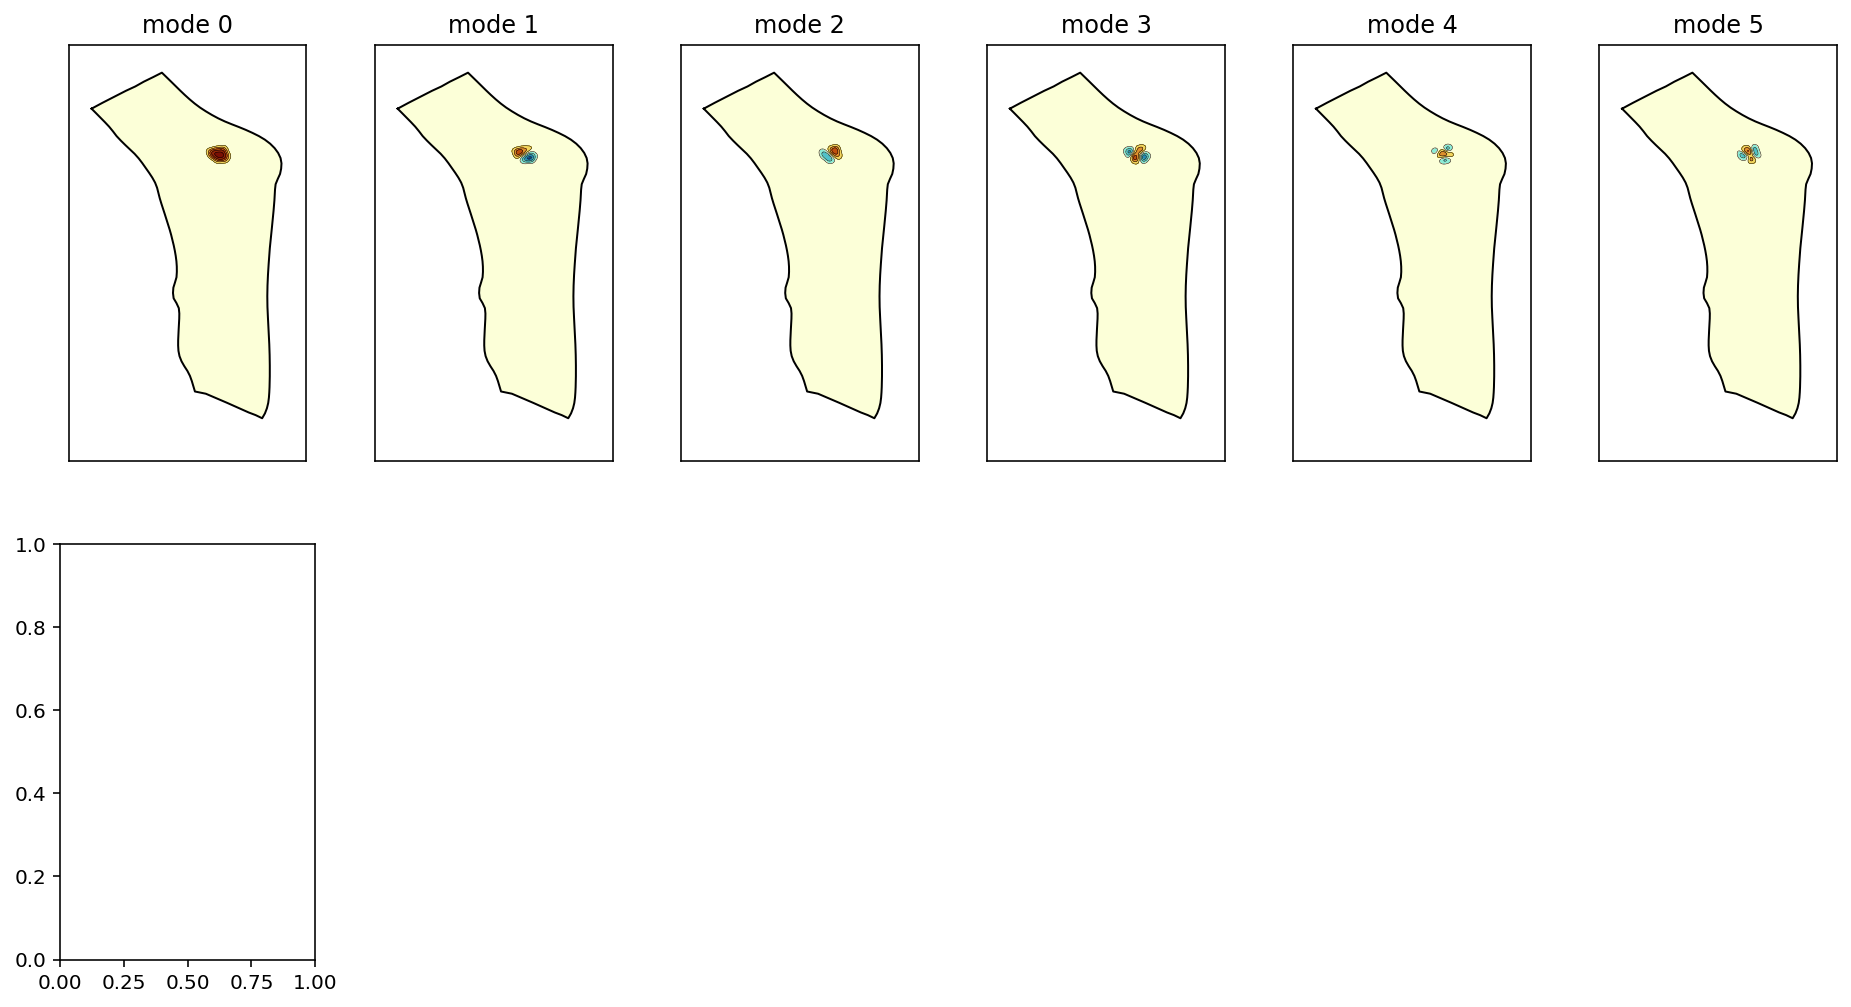

In [242]:
# Calculate eigenvales and eigenvectors for triangle subset
n_eigenvalues = event.triangle_index.size
event.eigenvalues, event.eigenvectors = get_eigenvalues_and_eigenvectors(
    n_eigenvalues,
    x_centroid[event.triangle_index],
    y_centroid[event.triangle_index],
    z_centroid[event.triangle_index],
)

N_CONTOUR_LEVELS = 10
# Visualize eigenvectors
def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    # If the fill value has very little variation so it can be contoured
    if fill_value.ptp() < 1e-4:
        fill_value = 1e-4 * np.ones_like(fill_value)

    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, N_CONTOUR_LEVELS)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


# Normalize fill_value for interpretable plotting
# fill_value = np.zeros(meshes[0].n_tde)
# fill_value[event.triangle_index] = event.eigenvectors[:, 30]
# min_value = np.min(fill_value)
# max_value = np.max(fill_value)
# if np.abs(max_value) > np.abs(min_value):
#     fill_value = fill_value / max_value
# else:
#     fill_value = fill_value / np.abs(min_value)

# if i == 0 and np.nanmean(fill_value) < 0:
#     fill_value = -1 * fill_value

# interpolate_and_plot(fill_value)
# plt.title(f"mode {i}")

def make_eigenvector_example_plot():
    n_eigenvalues = 200
    eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
        n_eigenvalues, meshes[0].x_centroid, meshes[0].y_centroid, meshes[0].z_centroid
    )

    # Plot select eigenmodes
    plt.figure(figsize=(16, 13))

    for i in range(0, 18):
        ax = plt.subplot(3, 6, i + 1)

        # Shift eigenmodes by plotting row to show some dynamic range
        if i > 5 and i <= 11:
            i = i - 6 + 30
        elif i > 11:
            i = i - 12 + 100
        # fill_value = fill_value = eigenvectors[:, i]
        fill_value = np.zeros(meshes[0].n_tde)
        fill_value[event.triangle_index] = event.eigenvectors[:, i]

        # Normalize fill_value for interpretable plotting
        min_value = np.min(fill_value)
        max_value = np.max(fill_value)
        if np.abs(max_value) > np.abs(min_value):
            fill_value = fill_value / max_value
        else:
            fill_value = fill_value / np.abs(min_value)

        if i == 0 and np.nanmean(fill_value) < 0:
            fill_value = -1 * fill_value

        interpolate_and_plot(fill_value)
        plt.title(f"mode {i}")
    
    plt.savefig("event_eigenvector_examples.pdf")
    plt.savefig("event_eigenvector_examples.png", dpi=500)
    plt.show()

make_eigenvector_example_plot()

(10,)
pre_scaled_moment=1.8962861182565306e+19
event.moment=array([9.09395325e+19])
slip_scaling_factor=array([4.79566515])


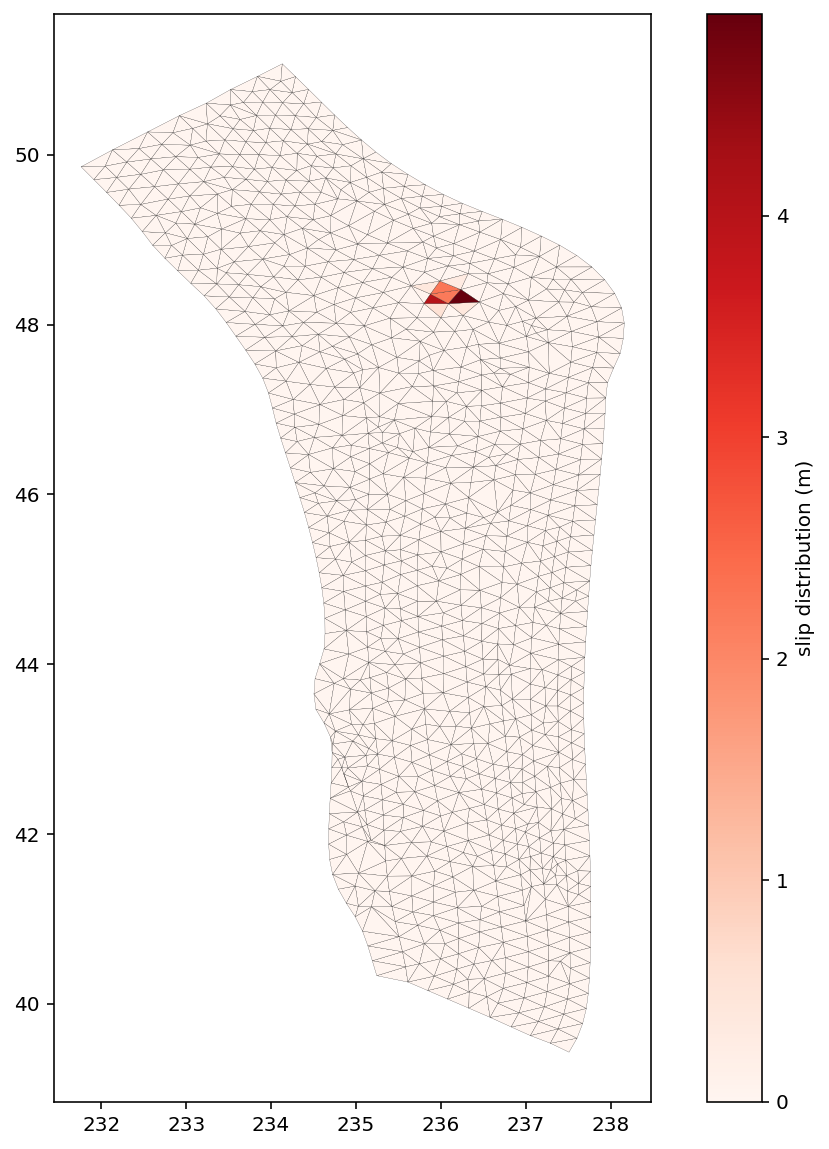

In [244]:
DYNECM_TO_NM = 1e-7

SHEAR_MODULUS = 3e10
event.moment = DYNECM_TO_NM * 10 ** (1.5 * (event.magnitude + 10.7))

event.moment = 10 ** (1.5 * (event.magnitude + 10.7) - 7.0)


event.mean_slip = event.moment / (SHEAR_MODULUS * event.actual_area)

kl_slip = np.zeros(event.triangle_index.size)

nterms = 10
z = np.random.randn(nterms)
for k in range(1, z.size):
    kl_slip += z[k] * np.sqrt(event.eigenvalues[k]) * event.eigenvectors[:, k]

kl_slip = np.exp(kl_slip)
print(kl_slip.shape)

# Apply taper to slip:
def normalized_sigmoid(a, b, x):
    """
    Returns array of a horizontal mirrored normalized sigmoid function
    output between 0 and 1
    Function parameters a = center; b = width
    https://stackoverflow.com/questions/3985619/how-to-calculate-a-logistic-sigmoid-function-in-python
    """
    s = 1 / (1 + np.exp(b * (x - a)))
    return 1 * (s - np.min(s)) / (np.max(s) - np.min(s))  # normalize function to 0-1


distances = hypocenter_triangle_to_all_triangles_distances[event.triangle_index]
taper_width = 1e-4  # TODO: Understand this term
taper_transition = np.mean(distances)
slip_taper = normalized_sigmoid(taper_transition, taper_width, distances)
kl_slip = kl_slip * slip_taper

# After taper is applied rescale slip magnitudes to get the correct moment
pre_scaled_moment = SHEAR_MODULUS * np.sum(
    kl_slip * meshes[0].areas[event.triangle_index]
)
slip_scaling_factor = event.moment / pre_scaled_moment
kl_slip = kl_slip * slip_scaling_factor

print(f"{pre_scaled_moment=}")
print(f"{event.moment=}")
print(f"{slip_scaling_factor=}")

# Plot triangle location
fill_value = np.zeros(meshes[0].n_tde)
fill_value[event.triangle_index] = kl_slip
plt.figure(figsize=(10, 10))
pc = plot_meshes(meshes, fill_value, plt.gca(), "Reds")
plt.colorbar(pc, label="slip distribution (m)")
plt.show()


$$M_W=\frac{2}{3}\log_{10}M_0 - 10.7$$

$$M_0=10^{\frac{3}{2}\left(M_W + 10.7\right)}$$


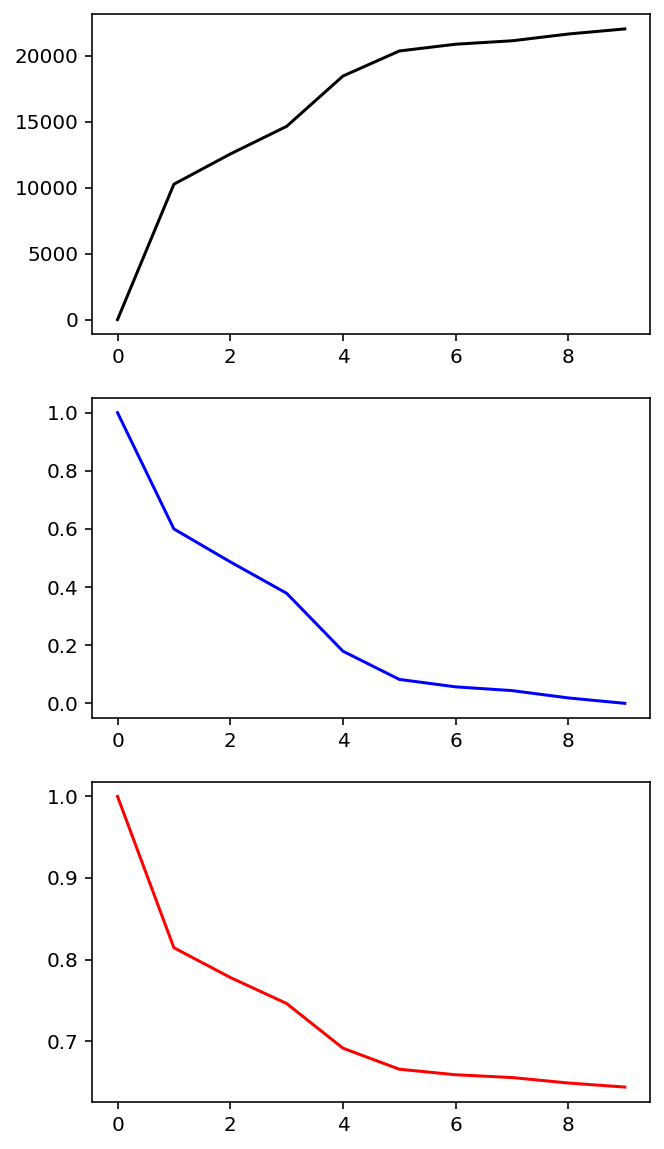

In [245]:
plt.figure(figsize=(5, 10))
plt.subplot(3, 1, 1)
plt.plot(distances, "-k")

plt.subplot(3, 1, 2)

taper_width = 1e-4 # m

taper_transition = np.mean(distances)

slip_taper_sigmoid = normalized_sigmoid(taper_transition, taper_width, distances)
plt.plot(slip_taper_sigmoid, "-b")

plt.subplot(3, 1, 3)
slip_taper_gaussian = np.exp(-distances / 5e4)
plt.plot(slip_taper_gaussian, "-r")

plt.show()


In [246]:
event.keys()
print(f"{event.magnitude=}")
print(f"{event.mean_slip=}")
print(f"{np.mean(kl_slip)=}")
print(f"{event.area / 1e6=}")
print(f"{event.target_area / 1e6=}")
print(f"{event.actual_area / 1e6=}")



event.magnitude=array([7.27250181])
event.mean_slip=array([1.55197792])
np.mean(kl_slip)=1.5139236329020902
event.area / 1e6=50000.0
event.target_area / 1e6=2000.0
event.actual_area / 1e6=1953.19644570399


In [232]:
event.moment = DYNECM_TO_NM * 10 ** (1.5 * (event.magnitude + 10.7))

In [ ]:
# TODO: Move constants to top of script
# TODO: Rescale slip to get correct event magnitude
# TODO: Convert from magnitude to area using Plescia & Hayes and Wells & Coppersmith
# TODO: Keep packing variables into event
